In [9]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json


In [ ]:
# prompt: extract to a folder
!unzip chest-xray-pneumonia.zip -d /content/chest-xray-pneumonia

In [12]:
# prompt: move all to a single directory called PneumoniaCxr NORMAL and PNEUMONIA Dont mixup Classes

import os
import shutil

# Define the source directory
source_dir = '/content/chest-xray-pneumonia/chest_xray'

# Define the destination directory
dest_dir = '/content/PneumoniaCxr'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Loop through the train, test, and val directories
for split in ['train', 'test', 'val']:
    split_dir = os.path.join(source_dir, split)
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(split_dir, class_name)
        for filename in os.listdir(class_dir):
            source_file = os.path.join(class_dir, filename)
            dest_file = os.path.join(dest_dir, class_name, filename)

            # Create the destination class directory if it doesn't exist
            if not os.path.exists(os.path.join(dest_dir, class_name)):
                os.makedirs(os.path.join(dest_dir, class_name))

            # Move the file
            shutil.move(source_file, dest_file)


In [14]:
# prompt: delete older folders
!rm -rf /content/chest-xray-pneumonia
!rm -rf /content/chest-xray-pneumonia.zip

In [3]:
# prompt: Show No of Classes in Train Test And Val data

import os
base = '/content/PneumoniaCxr'
def count_classes(directory):
  """
  Counts the number of classes in a directory.

  Args:
    directory: The path to the directory.

  Returns:
    A dictionary with the class names as keys and the number of images as values.
  """
  class_counts = {}
  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

# Count classes
counts = count_classes(f'{base}')
print("Train data classes:", counts)

Train data classes: {'train': 2, 'val': 2, 'test': 2}


In [23]:
import numpy as np
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
import glob

# Define the directory for the images
train_dir = base

# Define the data generator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Function to count images per class using glob
def count_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Use glob to filter non-augmented images
            image_files = glob.glob(os.path.join(class_path, '*[!augmented_]*.*'))
            class_counts[class_name] = len(image_files)
    return class_counts

# Get the class counts
train_counts = count_classes(train_dir)

# Find the class with the most images
max_count = max(train_counts.values())

# Loop through each class and augment the images
for class_name in train_counts:
    class_path = os.path.join(train_dir, class_name)
    count = train_counts[class_name]
    if count < max_count:
        # Calculate the number of images to generate
        num_images_to_generate = max_count - count

        # Get the image filenames using glob, excluding already augmented images
        image_filenames = glob.glob(os.path.join(class_path, '*[!augmented_]*.*'))

        # Generate augmented images
        for i in range(num_images_to_generate):
            # Select a random image
            random_image_index = np.random.randint(0, len(image_filenames))
            image_path = image_filenames[random_image_index]

            # Load the image
            img = cv2.imread(image_path)
            if img is None:
                continue  # Skip if the image is not loaded correctly
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Reshape the image to a batch of 1
            x = img.reshape((1,) + img.shape)

            # Generate augmented images
            it = datagen.flow(x, batch_size=1)
            batch = next(it)

            # Save the augmented image
            augmented_image = batch[0].astype('uint8')
            new_filename = f"augmented_{i}_{os.path.basename(image_filenames[random_image_index])}"
            new_image_path = os.path.join(class_path, new_filename)
            cv2.imwrite(new_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))


In [24]:
counts = count_classes(f'{base}')
print("Train data classes:", counts)

Train data classes: {'PNEUMONIA': 4273, 'NORMAL': 4273}


In [26]:
!zip -r /content/drive/MyDrive/PneumoniaCxr.zip /content/PneumoniaCxr > /dev/null

# **Loading From Drive**

In [5]:
!unzip /content/drive/MyDrive/PneumoniaCxr.zip -d /

# **Updating TF & Keras**

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [ ]:
import os
base = '/content/PneumoniaCxr'
def count_classes(directory):
  """
  Counts the number of classes in a directory.

  Args:
    directory: The path to the directory.

  Returns:
    A dictionary with the class names as keys and the number of images as values.
  """
  class_counts = {}
  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Base directory
base = '/content/PneumoniaCxr/'

# Directories for Normal and Pneumonia
normal_dir = os.path.join(base, 'NORMAL')
pneumonia_dir = os.path.join(base, 'PNEUMONIA')

# Helper function to move images to respective folders
def move_images(image_list, src_dir, dest_dir):
    for img in image_list:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.move(src_path, dest_path)

# Create new directories for train, val, and test splits
def create_split_folders(base_dir, split_names):
    for split in split_names:
        os.makedirs(os.path.join(base_dir, split, 'NORMAL'), exist_ok=True)
        os.makedirs(os.path.join(base_dir, split, 'PNEUMONIA'), exist_ok=True)

# Function to handle train/val/test split
def split_and_move_images(class_images, class_name, base_dir, split_ratio=(0.7, 0.15, 0.15), random_state=42):
    train_imgs, test_imgs = train_test_split(class_images, test_size=1-split_ratio[0], random_state=random_state)
    val_imgs, test_imgs = train_test_split(test_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=random_state)

    # Move images to respective folders
    move_images(train_imgs, os.path.join(base_dir, class_name), os.path.join(base_dir, 'train', class_name))
    move_images(val_imgs, os.path.join(base_dir, class_name), os.path.join(base_dir, 'val', class_name))
    move_images(test_imgs, os.path.join(base_dir, class_name), os.path.join(base_dir, 'test', class_name))

# List of files in each class
normal_images = os.listdir(normal_dir)
pneumonia_images = os.listdir(pneumonia_dir)

# Create split folders
split_names = ['train', 'val', 'test']
create_split_folders(base, split_names)

# Split and move images for both NORMAL and PNEUMONIA
split_and_move_images(normal_images, 'NORMAL', base)
split_and_move_images(pneumonia_images, 'PNEUMONIA', base)

# Remove old
!rm -rf /content/PneumoniaCxr/NORMAL
!rm -rf /content/PneumoniaCxr/PNEUMONIA

In [ ]:
train_counts = count_classes(f'{base}/train')
test_counts = count_classes(f'{base}/test')
val_counts = count_classes(f'{base}/val')
print("Train data classes:", train_counts)
print("Test data classes:", test_counts)
print("Validation data classes:", val_counts)

In [5]:
# Create data generators without augmentation, only rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_data = train_datagen.flow_from_directory(
    os.path.join(base, 'train'),
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    os.path.join(base, 'val'),
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    os.path.join(base, 'test'),
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 5982 images belonging to 2 classes.
Found 1282 images belonging to 2 classes.
Found 1282 images belonging to 2 classes.


In [20]:
# General Imports for Models
from keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [11]:
# Create the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
mnmodel = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained MobileNet
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
mnmodel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save the best model (lowest validation loss)
checkpoint = ModelCheckpoint(
    f"mnbest_model.keras{mnmodel}",         # File to save the best model
    monitor='val_loss',           # Monitor the validation loss
    save_best_only=True,          # Save only the best model
    mode='min',                   # Minimize the validation loss
    verbose=1                     # Verbosity level
)

# Define EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor the validation loss
    patience=4,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,    # Restore the best model weights
    verbose=1                     # Verbosity level
)

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Monitor the validation loss
    factor=0.5,                   # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,                   # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6,                  # Minimum learning rate allowed
    verbose=1                     # Verbosity level
)

# Train the model with checkpoint, early stopping, and learning rate reduction on plateau callbacks
historymn = mnmodel.fit(
    train_data,
    epochs=50,                    # Max number of epochs
    validation_data=val_data,
    callbacks=[checkpoint, early_stopping, reduce_lr]  # Include all callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.7990 - loss: 0.6674
Epoch 1: val_loss improved from inf to 0.14812, saving model to mnbest_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8000 - loss: 0.6637 - val_accuracy: 0.9532 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 2/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9541 - loss: 0.1266
Epoch 2: val_loss improved from 0.14812 to 0.10881, saving model to mnbest_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 780ms/step - accuracy: 0.9540 - loss: 0.1266 - val_accuracy: 0.9610 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 3/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9640 - loss: 0.0992
Epoch 3: val_loss improved from 0.10881 to 0.10330, saving model to mnbest_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 778ms/step - accuracy: 0.9639 - loss: 0.0993 - val_accuracy: 0.9672 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9669 -

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score,
                             log_loss, accuracy_score, precision_score,
                             recall_score, f1_score)

def evaluate_model_on_test_data(model, test_data, history=None):
    # Reset the generator to ensure starting from the beginning
    test_data.reset()

    # Get predictions and true labels
    predictions = model.predict(test_data, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

    true_classes = test_data.classes  # True labels from the generator

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes)
    recall = recall_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes)
    auc = roc_auc_score(true_classes, predictions)  # Use probabilities for AUC
    loss = log_loss(true_classes, predictions)        # Calculate Log Loss
    cm = confusion_matrix(true_classes, predicted_classes)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Log Loss: {loss:.4f}")

    # Create subplots for all visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_classes, predictions)
    axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
    axes[1].set_title('Receiver Operating Characteristic (ROC)')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')

    if history:
        # Plot Learning Curve
        epochs = np.arange(1, len(history.history['accuracy']) + 1)
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        axes[2].plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
        axes[2].plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
        axes[2].plot(epochs, train_loss, label='Train Loss', color='green')
        axes[2].plot(epochs, val_loss, label='Validation Loss', color='red')
        axes[2].set_title('Learning Curve')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Value')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1, auc, loss, cm


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 618ms/step
Accuracy: 0.9782
Precision: 0.9842
Recall: 0.9719
F1 Score: 0.9780
AUC: 0.9980
Log Loss: 0.0579


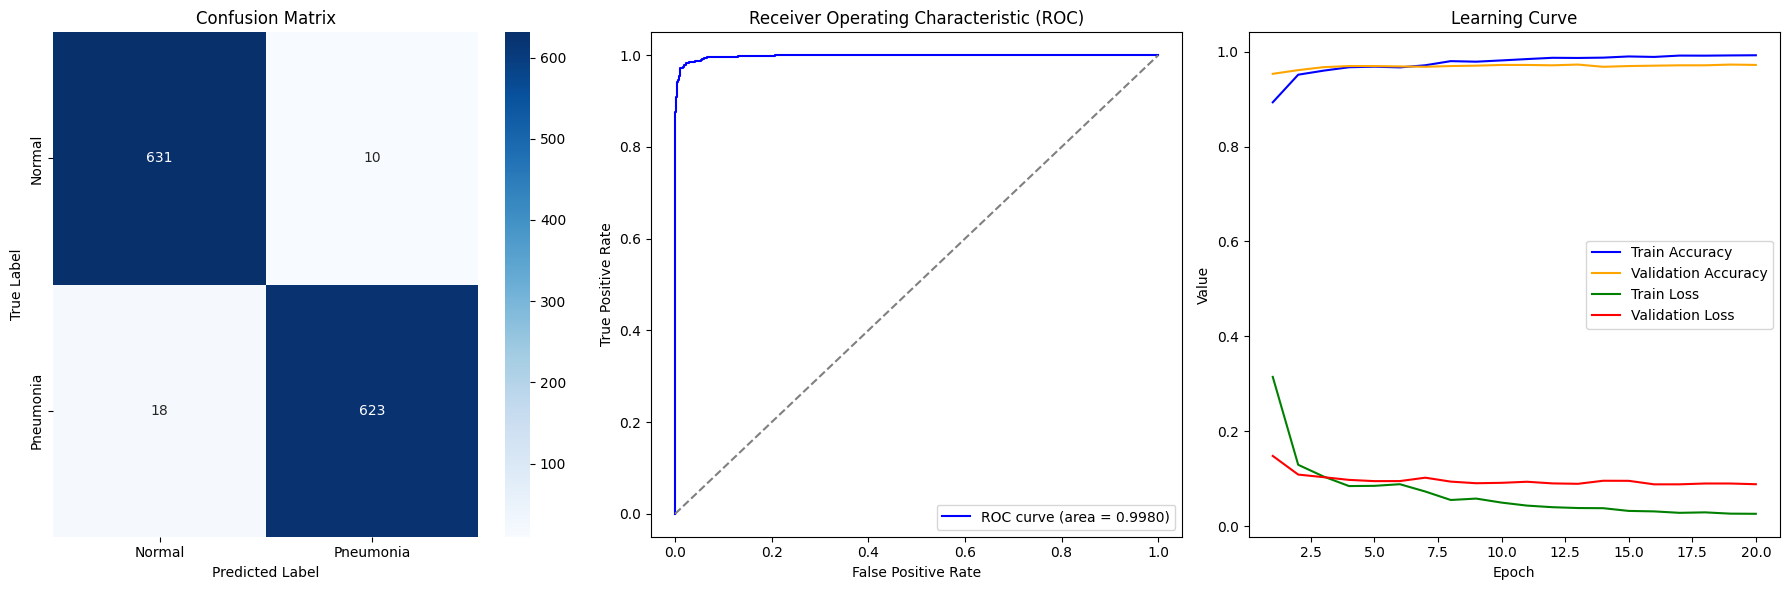

In [19]:
accuracy, precision, recall, f1, auc, loss, cm = evaluate_model_on_test_data(mnmodel, test_data,history=historymn)

# ***Analysis***
Accuracy (0.9782): The model correctly classified 97.82% of the test samples. This is very high, indicating that the model is performing well overall.

Precision (0.9842): Of all the instances predicted as positive (pneumonia), 98.42% were true positives. This shows that the model is very good at identifying positive cases without many false positives.

Recall (0.9719): Out of all the actual positive cases, the model identified 97.19%. This indicates that the model is good at capturing most of the positive cases, with only a small percentage of false negatives.

F1 Score (0.9780): The F1 score, which is the harmonic mean of precision and recall, is very high. It balances the trade-off between precision and recall, and a score close to 1 indicates excellent performance.

AUC (0.9980): The Area Under the Receiver Operating Characteristic (ROC) Curve is nearly 1, which suggests that the model is exceptionally good at distinguishing between the classes.

Log Loss (0.0579): This value measures the performance of the classification model where lower values indicate better performance. A log loss close to 0 suggests that the model's probability predictions are very accurate.